# Imports and loading in Dataset

In [1]:
%pip install pandas
%pip install numpy
%pip install keras
%pip install --upgrade tensorflow
%pip install wordcloud
%pip install flask
%pip install seaborn
%pip install scikit-learn==1.4.2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from flask import Flask, render_template_string
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, GRU, LSTM, Bidirectional, SimpleRNN
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from wordcloud import WordCloud
import threading
import webbrowser
from werkzeug.serving import make_server
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_csv("Phishing_Email.csv")

nRow, nCol = df.shape
print(f'Rows: {nRow} and Cols: {nCol}')

df.head(10)

Rows: 18650 and Cols: 3


,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,5,global risk management operations sally congra...,Safe Email
6,6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,9,re : coastal deal - with exxon participation u...,Safe Email


Preprocessing and Cleaning

In [4]:
df.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [5]:
#drop null vals
df.isnull().sum()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print("New data length:", len(df), "\n")

New data length: 18634 



In [6]:
df.isnull().sum()

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64

In [7]:
print("Dimension of row:",df.shape)

Dimension of row: (18634, 3)


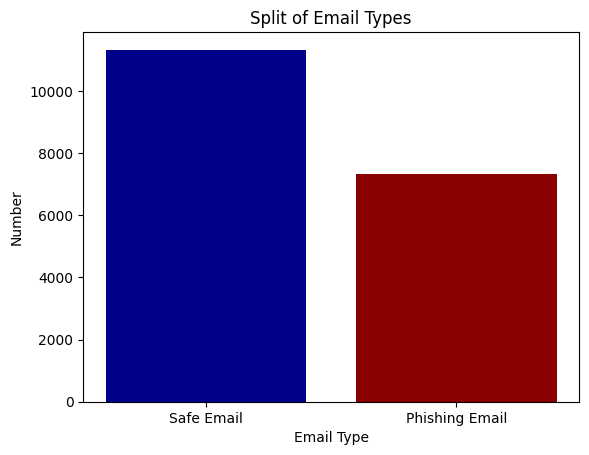

In [8]:
email_type = df['Email Type'].value_counts()
plt.bar(email_type.index, email_type.values, color=['darkblue', 'darkred'])
plt.xlabel('Email Type')
plt.ylabel('Number')
plt.title('Split of Email Types')

# Display the plot
plt.show()

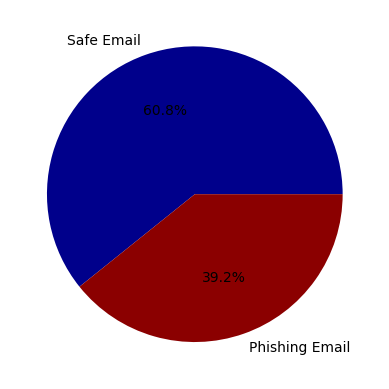

In [9]:
plt.pie(email_type, labels=email_type.index, colors=['darkblue', 'darkred'], autopct='%1.1f%%')

# Display the pie chart
plt.show()

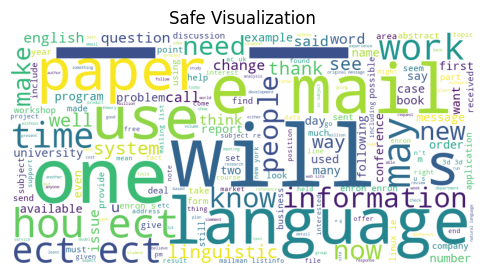

In [10]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
safe_type = df[df['Email Type'] == 'Safe Email']['Email Text'].astype(str).values
phishing_type = df[df['Email Type'] == 'Phishing Email']['Email Text'].astype(str).values

safe_type = ''.join(safe_type)
wordcloud.generate(safe_type)

plt.figure(figsize=(6, 7))
plt.imshow(wordcloud)
plt.title('Safe Visualization')
plt.axis("off")
plt.show()

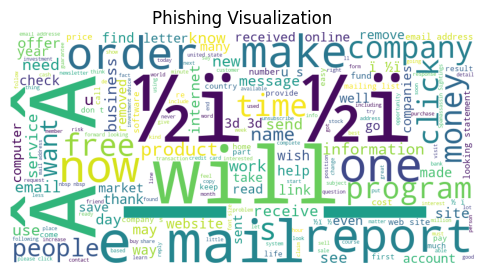

In [11]:
phishing_type = ''.join(phishing_type)
wordcloud.generate(phishing_type)

plt.figure(figsize=(6, 7))
plt.imshow(wordcloud)
plt.title('Phishing Visualization')
plt.axis("off")
plt.show()

In [12]:
# Vectorize email content using TF-IDF
tf = TfidfVectorizer(stop_words="english",max_features=10000)
feature_x = tf.fit_transform(df["Email Text"]).toarray()

y_tf = np.array(df['Email Type'])

# Split the dataset into training and test sets
X_train,X_test,y_train,y_test = train_test_split(feature_x,y_tf,train_size=0.8,random_state=0)

In [13]:
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

print("Instances per label in training:", y_train_series.value_counts())
print("Instances per label in test:", y_test_series.value_counts())

Instances per label in training: Safe Email        9052
Phishing Email    5855
Name: count, dtype: int64
Instances per label in test: Safe Email        2270
Phishing Email    1457
Name: count, dtype: int64


In [14]:
print(X_train[:2])
print(X_train.shape)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.04338204 0.         0.         ... 0.         0.         0.        ]]
(14907, 10000)


In [15]:
print(y_train)
print(y_train.shape)

['Safe Email' 'Safe Email' 'Phishing Email' ... 'Safe Email'
 'Phishing Email' 'Phishing Email']
(14907,)


# Models

In [16]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

nb.fit(X_train,y_train)

MultinomialNB()

# Naive Bayes

In [17]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import pickle

# Define and fit the TF-IDF vectorizer using the 'Email Text' column
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=10000)
X_vect = tfidf_vectorizer.fit_transform(df["Email Text"])  # Transform the full text column for training and testing

# Convert the labels into numpy array
y = np.array(df['Email Type'])

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train_vect, X_test_vect, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=0)

# Train the Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_vect, y_train)

# Predict on the test set using Naive Bayes classifier
pred_nav = nb.predict(X_test_vect)

# Print accuracy
print(f"Accuracy from Naive Bayes: {accuracy_score(y_test, pred_nav) * 100:.2f} %")

# Print F1 score (weighted average for multi-class classification)
print(f"F1 score from Naive Bayes: {f1_score(y_test, pred_nav, average='weighted') * 100:.2f} %")

# Print the classification report
print("Classification Report:\n", classification_report(y_test, pred_nav))

# Save the Naive Bayes model
with open('naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(nb, model_file)

# Save the TF-IDF vectorizer
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

# Additional evaluation metrics for clarity
print("Naive Bayes Evaluation Metrics:")
print(classification_report(y_test, pred_nav, target_names=['Safe', 'Phishing']))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_nav))

Accuracy from Naive Bayes: 95.12 %
F1 score from Naive Bayes: 95.09 %
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.97      0.91      0.94      1457
    Safe Email       0.94      0.98      0.96      2270

      accuracy                           0.95      3727
     macro avg       0.95      0.94      0.95      3727
  weighted avg       0.95      0.95      0.95      3727

Naive Bayes Evaluation Metrics:
              precision    recall  f1-score   support

        Safe       0.97      0.91      0.94      1457
    Phishing       0.94      0.98      0.96      2270

    accuracy                           0.95      3727
   macro avg       0.95      0.94      0.95      3727
weighted avg       0.95      0.95      0.95      3727

Confusion Matrix:
 [[1320  137]
 [  45 2225]]


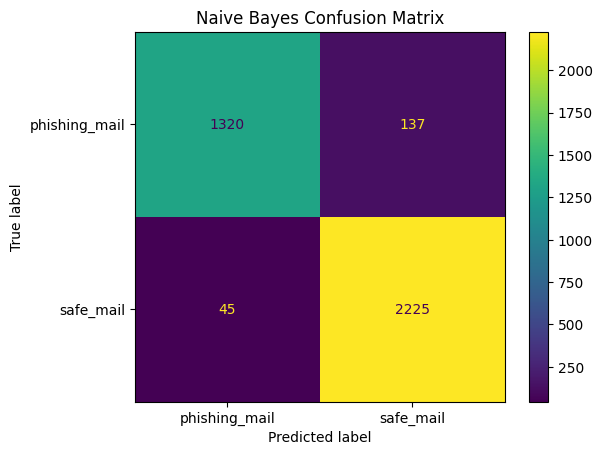

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
clf_nav = confusion_matrix(y_test, pred_nav)

# Display confusion matrix
cx_ = ConfusionMatrixDisplay(confusion_matrix=clf_nav, display_labels=['phishing_mail', 'safe_mail'])
cx_.plot(cmap='viridis') 
plt.title("Naive Bayes Confusion Matrix")
plt.show()

# Decision Tree

Accuracy from Decision Tree: 92.57 %
F1 score from Decision Tree: 92.60 %
Classification report:
                 precision    recall  f1-score   support

Phishing Email       0.88      0.93      0.91      1457
    Safe Email       0.96      0.92      0.94      2270

      accuracy                           0.93      3727
     macro avg       0.92      0.93      0.92      3727
  weighted avg       0.93      0.93      0.93      3727

Decision Tree Evaluation Metrics:
              precision    recall  f1-score   support

        Safe       0.88      0.93      0.91      1457
    Phishing       0.96      0.92      0.94      2270

    accuracy                           0.93      3727
   macro avg       0.92      0.93      0.92      3727
weighted avg       0.93      0.93      0.93      3727

Confusion Matrix:
 [[1360   97]
 [ 180 2090]]


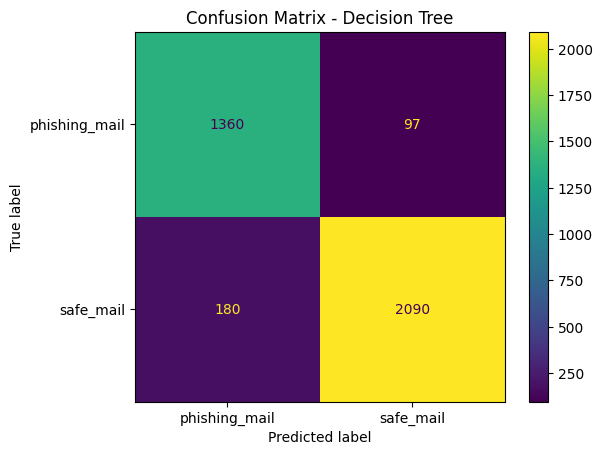

In [19]:
dtr = DecisionTreeClassifier()
dtr = DecisionTreeClassifier() # Creating the classifier object
dtr.fit(X_train, y_train)

#Prediction on the test set
pred_dtr = dtr.predict(X_test)

#Performance evaluation
print(f"Accuracy from Decision Tree: {accuracy_score(y_test, pred_dtr) * 100:.2f} %")
print(f"F1 score from Decision Tree: {f1_score(y_test, pred_dtr, average='weighted') * 100:.2f} %")
print("Classification report:\n", classification_report(y_test, pred_dtr))


print("Decision Tree Evaluation Metrics:")
print(classification_report(y_test, pred_dtr, target_names=['Safe', 'Phishing']))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_dtr))
#Confusion Matrix
clf_dtr = confusion_matrix(y_test, pred_dtr)
ConfusionMatrixDisplay(clf_dtr, display_labels=['phishing_mail', 'safe_mail']).plot()
plt.title("Confusion Matrix - Decision Tree")
plt.show()

import pickle

# Saving the Decision Tree model to 'decision_tree_model.pkl'
with open('decision_tree_model.pkl', 'wb') as dt_file:
    pickle.dump(dtr, dt_file)

# Random Forest

Accuracy from Random Forest: 96.49%
F1 score from Random Forest: 96.50%
Classification Report:
               precision    recall  f1-score   support

        Safe       0.93      0.98      0.96      1457
    Phishing       0.99      0.96      0.97      2270

    accuracy                           0.96      3727
   macro avg       0.96      0.97      0.96      3727
weighted avg       0.97      0.96      0.96      3727



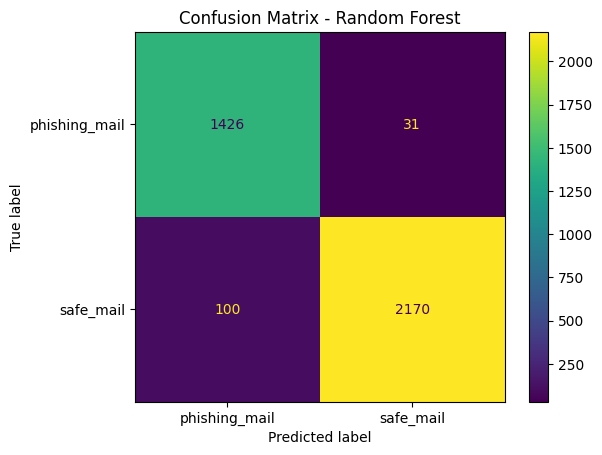

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

# Initialize and train the Random Forest model
rnf = RandomForestClassifier()
rnf.fit(X_train, y_train)

# Prediction
pred_rnf = rnf.predict(X_test)

# Performance metrics
print(f"Accuracy from Random Forest: {accuracy_score(y_test, pred_rnf) * 100:.2f}%")
print(f"F1 score from Random Forest: {f1_score(y_test, pred_rnf, average='weighted') * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, pred_rnf, target_names=['Safe', 'Phishing']))

# Confusion Matrix Display
clf_rnf = confusion_matrix(y_test, pred_rnf)
ConfusionMatrixDisplay(confusion_matrix=clf_rnf, display_labels=['phishing_mail', 'safe_mail']).plot(cmap='viridis')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Save the Random Forest model
with open('random_forest_model.pkl', 'wb') as rf_file:
    pickle.dump(rnf, rf_file)  # Save the trained model

# SGDClassifier

In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Step 1: Initialize individual models, including SGDClassifier with correct 'log_loss' parameter
nb_model = MultinomialNB()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
sgd_model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)  # Corrected parameter to 'log_loss'

# Step 2: Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('nb', nb_model),
    ('dt', dt_model),
    ('rf', rf_model),
    ('sgd', sgd_model)
], voting='soft')  # Soft voting for probability averaging

# Step 3: Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
ensemble_pred = ensemble_model.predict(X_test)

# Step 5: Evaluate the ensemble model
print(f"Ensemble Model Accuracy: {accuracy_score(y_test, ensemble_pred) * 100:.2f}%")
print(f"Ensemble Model F1 Score: {f1_score(y_test, ensemble_pred, average='weighted') * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, ensemble_pred))

# Display confusion matrix for detailed error analysis
conf_matrix = confusion_matrix(y_test, ensemble_pred)
print("Confusion Matrix:\n", conf_matrix)

Ensemble Model Accuracy: 96.91%
Ensemble Model F1 Score: 96.93%
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.94      0.98      0.96      1457
    Safe Email       0.99      0.96      0.97      2270

      accuracy                           0.97      3727
     macro avg       0.96      0.97      0.97      3727
  weighted avg       0.97      0.97      0.97      3727

Confusion Matrix:
 [[1431   26]
 [  89 2181]]


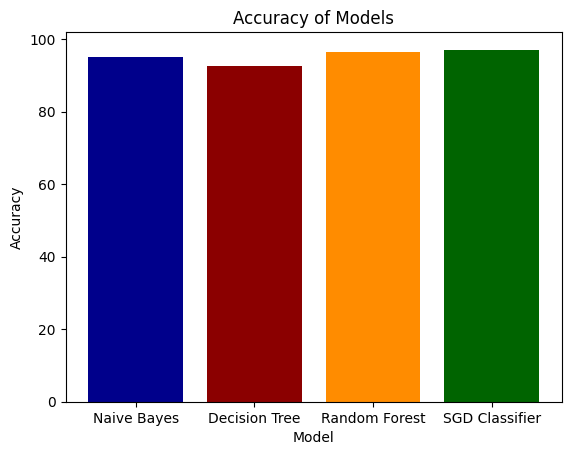

In [22]:
models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'SGD Classifier']
accuracies = [95.12, 92.70, 96.54, 97.10]

plt.bar(models, accuracies, color=['darkblue', 'darkred', 'darkorange', 'darkgreen'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Models')

# Display the plot
plt.show()

# LSTM / RNN

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle

max_length = 150

tk = Tokenizer()
tk.fit_on_texts(df['Email Text'])

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tk, tokenizer_file)

# Convert text to sequences and pad to max_length
sequences = tk.texts_to_sequences(df['Email Text'])
vector = pad_sequences(sequences, padding='post', maxlen=max_length)  # Ensure maxlen is consistent here

In [45]:
x = np.array(vector)
y = np.array(df["Email Type"])

X_train, X_test, y_train, y_test = train_test_split(vector,df['Email Type'], test_size=0.2, random_state =0)

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
import numpy as np

max_length = 150  # Define max length for padding sequences

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tk.word_index)+1, output_dim=100))  # Removed input_length
model.add(LSTM(units=200, return_sequences=True))
model.add(LSTM(units=100, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the model by calling it on sample data to initialize weights
sample_data = np.zeros((1, max_length))  # Create a sample batch with the correct input shape
model(sample_data)  # This initializes the model weights

# Save the model
model.save('lstm_model.keras')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (1, 150, 100)          │    16,660,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (1, 150, 200)          │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (1, 100)               │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (1, 100)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 1)                 │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,021,701 (64.93 MB)

 Trainable params: 17,021,701 (64.93 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
lstm_history  = model.fit(X_train,y_train, epochs=50, batch_size=16, validation_data=(X_test,y_test), callbacks=[early_stop, reduce_lr])

pd.DataFrame(lstm_history.history).plot(kind='line', xlabel='epochs', figsize=(8, 6))
plt.show()

Epoch 1/50


UnimplementedError: Graph execution error:

Detected at node compile_loss/binary_crossentropy/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\httrf\AppData\Local\Temp\ipykernel_13800\1814812613.py", line 1, in <module>

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 359, in _compute_loss

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 327, in compute_loss

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 611, in __call__

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 652, in call

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 56, in __call__

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\tree\tree_api.py", line 148, in map_structure

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\tree\optree_impl.py", line 79, in map_structure

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\optree\ops.py", line 747, in tree_map

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 57, in <lambda>

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\core.py", line 822, in convert_to_tensor

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\core.py", line 132, in convert_to_tensor

Cast string to float is not supported
	 [[{{node compile_loss/binary_crossentropy/Cast}}]] [Op:__inference_one_step_on_iterator_52319]

In [43]:
results = model.evaluate(X_test, y_test)
loss = results[0]
accuracy = results[1]

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy*100}")

UnimplementedError: Graph execution error:

Detected at node compile_loss/binary_crossentropy/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\httrf\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\httrf\AppData\Local\Temp\ipykernel_13800\1639685313.py", line 1, in <module>

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 433, in evaluate

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 165, in one_step_on_iterator

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 154, in one_step_on_data

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 85, in test_step

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 359, in _compute_loss

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 327, in compute_loss

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 611, in __call__

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 652, in call

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 56, in __call__

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\tree\tree_api.py", line 148, in map_structure

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\tree\optree_impl.py", line 79, in map_structure

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\optree\ops.py", line 747, in tree_map

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 57, in <lambda>

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\core.py", line 822, in convert_to_tensor

  File "c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\core.py", line 132, in convert_to_tensor

Cast string to float is not supported
	 [[{{node compile_loss/binary_crossentropy/Cast}}]] [Op:__inference_one_step_on_iterator_26527]

In [ ]:
y_test_pred_prob = model.predict(X_test)
y_train_pred_prob = model.predict(X_train)

#y_train_pred = np.argmax(y_train_pred_prob, axis=1)
#y_test_pred = np.argmax(y_test_pred_prob, axis=1)
y_pred = (y_test_pred_prob > 0.5).astype(int)

In [ ]:
pd.DataFrame(lstm_history.history)

pd.DataFrame(lstm_history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(lstm_history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
cnf = confusion_matrix(y_test,y_pred)
ax = ConfusionMatrixDisplay(confusion_matrix=cnf,display_labels=['Phishing','Benign'])
ax.plot()
plt.title("Confusion Matrix")
plt.show()

In [27]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
historical  = model.fit(X_train,y_train, epochs=2, batch_size=16, validation_data=(X_test,y_test))

Epoch 1/2
932/932 ━━━━━━━━━━━━━━━━━━━━ 299s 265ms/step - accuracy: 0.6493 - loss: 0.6316 - val_accuracy: 0.7298 - val_loss: 0.5218
Epoch 2/2
932/932 ━━━━━━━━━━━━━━━━━━━━ 244s 262ms/step - accuracy: 0.7056 - loss: 0.5454 - val_accuracy: 0.9391 - val_loss: 0.1821


# Phishing Detection Email Website

# Import Libraries

In [1]:
from flask import Flask, request, render_template_string, url_for
import webbrowser
import threading
from werkzeug.serving import make_server
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from tensorflow.keras.models import load_model
import time

# Load Models and Vectorizer

In [2]:
# Load traditional ML models
with open('naive_bayes_model.pkl', 'rb') as nb_file:
    naive_bayes_model = pickle.load(nb_file)

with open('decision_tree_model.pkl', 'rb') as dt_file:
    decision_tree_model = pickle.load(dt_file)

with open('random_forest_model.pkl', 'rb') as rf_file:
    random_forest_model = pickle.load(rf_file)

# Load TF-IDF vectorizer
with open('vectorizer.pkl', 'rb') as tfidf_file:
    tfidf_vectorizer = pickle.load(tfidf_file)

# Load tokenizer for LSTM
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    lstm_tokenizer = pickle.load(tokenizer_file)

lstm_model = load_model('lstm_model.keras')

# Recompile the model to reset the optimizer
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\httrf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Define the detect_phishing Function

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to detect phishing
def detect_phishing(email_content, algorithm):
    if algorithm == 'Naive Bayes':
        email_vector = tfidf_vectorizer.transform([email_content])
        prediction = naive_bayes_model.predict_proba(email_vector)[:, 0]
    elif algorithm == 'Decision Tree':
        email_vector = tfidf_vectorizer.transform([email_content])
        prediction = decision_tree_model.predict_proba(email_vector)[:, 0]
    elif algorithm == 'Random Forest':
        email_vector = tfidf_vectorizer.transform([email_content])
        prediction = random_forest_model.predict_proba(email_vector)[:, 0]
    
    elif algorithm == 'LSTM':
        # Convert email content to sequences using the tokenizer
        email_seq = lstm_tokenizer.texts_to_sequences([email_content])
        
        # Pad the sequences to the correct length
        email_seq_padded = pad_sequences(email_seq, maxlen=150)  # Adjust maxlen to match model training
        
        # Ensure the input has the correct shape (batch_size, sequence_length)
        email_seq_padded = np.array(email_seq_padded).reshape(1, -1)
        
        # Get the prediction from the LSTM model
        prediction = lstm_model.predict(email_seq_padded)[0]
    
    # Return the prediction value
    return prediction[0]

# Flask App Setup

In [4]:
# Flask app setup
app = Flask(__name__)


# HTML Template for Detection Overview Page

In [5]:
# HTML template for "Detection Overview" page
detection_overview = '''
<!DOCTYPE html>
<html lang="en">

<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Phishing Email Detection </title>
    <link rel="icon" href="{{ url_for('static', filename='favicon.ico') }}" type="image/x-icon">
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.3/css/all.min.css">
    <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@300;400;500;700&display=swap" rel="stylesheet">
    <style>
        * {
            box-sizing: border-box;
        }

        body {
            font-family: 'Roboto', sans-serif;
            background: linear-gradient(to bottom right, #667eea, #764ba2);
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
            margin: 0;
            color: #333;
        }

        .container {
            background: white;
            border-radius: 15px;
            padding: 40px;
            box-shadow: 0 15px 25px rgba(0, 0, 0, 0.2);
            max-width: 600px;
            width: 100%;
            animation: fadeIn 0.7s ease-in-out;
        }

        header {
            font-size: 2rem;
            font-weight: 700;
            color: #343a40;
            margin-bottom: 30px;
            text-align: center;
            position: relative;
        }

        header::after {
            content: '';
            display: block;
            width: 60px;
            height: 4px;
            background: linear-gradient(to right, #667eea, #764ba2);
            margin: 15px auto 0;
            border-radius: 3px;
        }

        .icon {
            font-size: 4rem;
            color: #764ba2;
            margin-bottom: 15px;
            animation: bounce 1.5s infinite;
        }

        .tabs {
            display: flex;
            justify-content: space-between;
            margin-bottom: 20px;
            text-align: center;
        }

        .tab-item {
            flex: 1;
            text-align: center;
        }

        .tabs img {
            width: 70px;
            cursor: pointer;
            transition: transform 0.3s ease;
        }

        .tabs img:hover {
            transform: scale(1.1);
        }

        .tab-label {
            text-align: center;
            font-weight: bold;
            margin-top: 5px;
            color: #495057;
        }

        .info-content {
            font-size: 1.1rem;
            text-align: center;
            margin-top: 20px;
        }

        .info-content p {
            display: none;
        }

        .info-content p.active {
            display: block;
        }

        button {
            width: 100%;
            padding: 15px;
            background: linear-gradient(to right, #667eea, #764ba2);
            color: white;
            border: none;
            border-radius: 8px;
            font-size: 1.2rem;
            font-weight: 500;
            cursor: pointer;
            transition: background-color 0.4s ease, transform 0.2s ease;
            margin-top: 20px;
            box-shadow: 0 3px 10px rgba(0, 0, 0, 0.2);
        }

        button:hover {
            transform: translateY(-3px);
            box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);
        }

        button:active {
            transform: translateY(0);
            box-shadow: none;
        }

        .about-us-content {
            display: none;
        }

        .about-us h3 {
            cursor: pointer;
            color: #764ba2;
            text-align: center;
            margin-top: 30px;
        }

        .team-members {
            display: flex;
            justify-content: space-around;
            margin-top: 20px;
        }

        .team-member {
            text-align: center;
        }

        .team-member h4 {
            font-size: 1.2rem;
            color: #764ba2;
        }

        footer {
            margin-top: 30px;
            font-size: 0.9rem;
            color: #6c757d;
            text-align: center;
        }

        /* Keyframes for Animations */
        @keyframes fadeIn {
            from {
                opacity: 0;
                transform: translateY(20px);
            }

            to {
                opacity: 1;
                transform: translateY(0);
            }
        }

        @keyframes bounce {
            0%, 100% {
                transform: translateY(0);
            }

            50% {
                transform: translateY(-10px);
            }
        }
    </style>
    <script>
        function showContent(id) {
            var contents = document.querySelectorAll('.info-content p');
            contents.forEach(function(content) {
                content.classList.remove('active');
            });
            document.getElementById(id).classList.add('active');
        }

        function toggleAboutUs() {
            var aboutContent = document.getElementById('about-us-content');
            if (aboutContent.style.display === 'none' || aboutContent.style.display === '') {
                aboutContent.style.display = 'block';  // Show the content when clicked
            } else {
                aboutContent.style.display = 'none';  // Hide the content when clicked again
            }
        }
    </script>
</head>

<body>
    <div class="container">
        <header>
            <i class="fas fa-shield-alt icon"></i>
            Phishing Defense Suite
        </header>
        <div class="tabs">
             <div class="tab-item">
                <img src="{{ url_for('static', filename='image2.webp') }}" alt="Probability Icon" onclick="showContent('probability')">
                <p class="tab-label">Probability Analysis</p>
            </div>
            <div class="tab-item">
                <img src="{{ url_for('static', filename='image3.webp') }}" alt="Real-Time Icon" onclick="showContent('realtime')">
                <p class="tab-label">Real-Time Detection</p>
            </div>
            <div class="tab-item">
                <img src="{{ url_for('static', filename='image4.webp') }}" alt="ML Icon" onclick="showContent('ml')">
                <p class="tab-label">Machine Learning</p>
            </div>
        </div>
        <div class="info-content">
            <p id="probability">Our probability analysis enhances detection by estimating the risk level of each email, supporting the chosen algorithm with an added layer of predictive accuracy.</p>
            <p id="realtime">Our real-time phishing detection system analyzes emails as they are received, identifying threats instantly to keep users safe.</p>
            <p id="ml">Our machine learning technology identifies phishing by recognizing subtle patterns in email content, continuously refining its accuracy as it learns from new data.</p>
        </div>
        <a href="/form"><button><i class="fas fa-arrow-right"></i> Proceed to Check for Phishing</button></a>

        <!-- Clickable About Us Section with Team Members -->
        <div class="about-us">
            <h3 onclick="toggleAboutUs()">About Us</h3>
            <div id="about-us-content" class="about-us-content" style="display:none;">
                <p>We are a passionate team focused on delivering cutting-edge phishing detection technologies to safeguard users from cyber threats and ensure a secure online experience.</p>
                <h4 style="text-align:center; color:#764ba2;">Team Members</h4>
                <div class="team-members">
                    <div class="team-member">
                        <h4>Latia Maree</h4>
                        <p>IT</p>
                        <p>Front-End Developer</p>
                    </div>
                    <div class="team-member">
                        <h4>Kensley Benjamin</h4>
                        <p>CS</p>
                        <p>Back-End Developer</p>
                    </div>
                </div>
            </div>
        </div>

        <footer>
            Phishing Detection &copy; 2024 | Stay Safe Online
        </footer>
    </div>

</body>

</html>
'''


# HTML Template for the Form Page

In [6]:
form_page = ''' 
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Phishing Email Detection</title>
    <link rel="icon" href="{{ url_for('static', filename='favicon.ico') }}" type="image/x-icon">
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.3/css/all.min.css">
    <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@300;400;500;700&display=swap" rel="stylesheet">
    <style>
        * {
            box-sizing: border-box;
        }

        body {
            font-family: 'Roboto', sans-serif;
            background: linear-gradient(to bottom right, #667eea, #764ba2);
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
            margin: 0;
            color: #333;
        }

        .container {
            background: white;
            border-radius: 15px;
            padding: 40px;
            box-shadow: 0 15px 25px rgba(0, 0, 0, 0.2);
            max-width: 600px;
            width: 100%;
            animation: fadeIn 0.7s ease-in-out;
        }

        header {
            font-size: 2rem;
            font-weight: 700;
            color: #343a40;
            margin-bottom: 30px;
            text-align: center;
            position: relative;
        }

        header::after {
            content: '';
            display: block;
            width: 60px;
            height: 4px;
            background: linear-gradient(to right, #667eea, #764ba2);
            margin: 15px auto 0;
            border-radius: 3px;
        }

        .icon {
            font-size: 4rem;
            color: #764ba2;
            margin-bottom: 15px;
            animation: bounce 1.5s infinite;
        }

        .form-group {
            margin-bottom: 25px;
        }

        .form-group label {
            display: block;
            font-weight: 500;
            margin-bottom: 8px;
            color: #495057;
        }

        textarea {
            width: 100%;
            padding: 15px;
            border: 2px solid #dee2e6;
            border-radius: 10px;
            font-size: 1.1rem;
            transition: border-color 0.3s ease;
            resize: none;
            min-height: 180px;
            box-shadow: 0 3px 8px rgba(0, 0, 0, 0.1);
        }

        textarea:focus {
            border-color: #764ba2;
            outline: none;
        }

        .toggle-button {
            width: 100%;
            padding: 15px;
            background: linear-gradient(to right, #667eea, #764ba2);
            color: white;
            border: none;
            border-radius: 8px;
            font-size: 1.2rem;
            font-weight: 500;
            cursor: pointer;
            transition: background-color 0.4s ease, transform 0.2s ease;
            margin-top: 20px;
            box-shadow: 0 3px 10px rgba(0, 0, 0, 0.2);
        }

        .toggle-button:hover {
            transform: translateY(-3px);
            box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);
        }

        .toggle-button:active {
            transform: translateY(0);
            box-shadow: none;
        }

        #algorithm-options {
            display: none;
            margin-top: 20px;
        }

        .custom-radio-wrapper {
            display: flex;
            align-items: center;
            margin-bottom: 10px;
            color: white;
        }

        .custom-radio-wrapper input {
            margin-right: 10px;
        }

        #naive_bayes + label,
        #decision_tree + label,
        #random_forest + label,
        #lstm + label {
            background: linear-gradient(to right, #667eea, #764ba2);
            padding: 10px;
            border-radius: 5px;
            width: 100%;
            color: white;
            cursor: pointer;
            transition: background-color 0.4s ease, transform 0.2s ease;
            box-shadow: 0 3px 10px rgba(0, 0, 0, 0.2);
        }

        #naive_bayes + label:hover,
        #decision_tree + label:hover,
        #random_forest + label:hover,
        #lstm + label:hover {
            transform: translateY(-3px);
            box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);
        }

        button {
            width: 100%;
            padding: 15px;
            background: linear-gradient(to right, #667eea, #764ba2);
            color: white;
            border: none;
            border-radius: 8px;
            font-size: 1.2rem;
            font-weight: 500;
            cursor: pointer;
            transition: background-color 0.4s ease, transform 0.2s ease;
            margin-top: 20px;
            box-shadow: 0 3px 10px rgba(0, 0, 0, 0.2);
        }

        button:hover {
            transform: translateY(-3px);
            box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);
        }

        button:active {
            transform: translateY(0);
            box-shadow: none;
        }

        .result {
            margin-top: 30px;
            padding: 20px;
            background-color: #f8f9fa;
            border-left: 5px solid #764ba2;
            border-radius: 10px;
            font-size: 1.1rem;
            text-align: left;
            animation: fadeIn 0.7s ease-in-out;
            box-shadow: 0 2px 10px rgba(0, 0, 0, 0.1);
        }

        .result.negative {
            background-color: #f8d7da;
            border-left-color: #dc3545;
            color: #721c24;
        }

        .result h3 {
            margin: 0;
            font-weight: 600;
        }

        footer {
            margin-top: 30px;
            font-size: 0.9rem;
            color: #6c757d;
            text-align: center;
        }

        @media (max-width: 768px) {
            .container {
                padding: 20px;
            }

            header {
                font-size: 1.8rem;
            }

            textarea {
                min-height: 140px;
            }

            button {
                font-size: 1rem;
            }
        }

        @keyframes fadeIn {
            from {
                opacity: 0;
                transform: translateY(20px);
            }

            to {
                opacity: 1;
                transform: translateY(0);
            }
        }

        @keyframes bounce {
            0%, 100% {
                transform: translateY(0);
            }

            50% {
                transform: translateY(-10px);
            }
        }
    </style>

    <script>
        console.log("JavaScript loaded!");  // Debugging message

        function toggleAlgorithmOptions() {
            var options = document.getElementById('algorithm-options');
            var checkButton = document.getElementById('check-phishing-btn');
            if (options.style.display === 'none' || options.style.display === '') {
                options.style.display = 'block';
                checkButton.disabled = false;  // Enable the "Check for Phishing" button after selecting algorithm
            } else {
                options.style.display = 'none';
                checkButton.disabled = true;  // Disable button if options are hidden
            }
        }

        function validateAlgorithmSelection(event) {
            console.log("Validating algorithm selection...");  // Debugging step
            const algorithms = document.getElementsByName('algorithm');
            let algorithmSelected = false;

            for (const algorithm of algorithms) {
                if (algorithm.checked) {
                    algorithmSelected = true;
                    break;
                }
            }

            if (!algorithmSelected) {
                event.preventDefault();  // Prevent form submission
                console.log("No algorithm selected.");  // Debugging log
                alert("Please select an algorithm before submitting.");  // Alert the user
                return false;  // Block submission
            }
            console.log("Algorithm selected.");  // Debugging log
            return true;  // Allow form submission
        }
    </script>
</head>

<body>

    <div class="container">
        <header>
            <i class="fas fa-shield-alt icon"></i>
            Phishing Email Detection
        </header>
        <!-- Ensure the form uses the correct validation function -->
        <form action="/result" method="POST" onsubmit="validateAlgorithmSelection(event)">
            <div class="form-group">
                <label for="email">Email Content:</label>
                <textarea id="email" name="email" placeholder="Paste the email content here..." required></textarea>
            </div>

            <!-- Toggle Button for Algorithm Selection -->
            <button id="choose-algorithm-btn" type="button" class="toggle-button" onclick="toggleAlgorithmOptions()">
                <i class="fas fa-cogs"></i> Choose Algorithm
            </button>

            <!-- Hidden Algorithm Options -->
            <div id="algorithm-options" style="display: none;">
                <div class="custom-radio-wrapper">
                    <input type="radio" id="naive_bayes" name="algorithm" value="Naive Bayes" checked>
                    <label for="naive_bayes">Naive Bayes</label>
                </div>
                <div class="custom-radio-wrapper">
                    <input type="radio" id="decision_tree" name="algorithm" value="Decision Tree">
                    <label for="decision_tree">Decision Tree</label>
                </div>
                <div class="custom-radio-wrapper">
                    <input type="radio" id="random_forest" name="algorithm" value="Random Forest">
                    <label for="random_forest">Random Forest</label>
                </div>
                <div class="custom-radio-wrapper">
                    <input type="radio" id="lstm" name="algorithm" value="LSTM">
                    <label for="lstm">LSTM Neural Network</label>
                </div>
            </div>

            <!-- Initially disabled "Check for Phishing" button -->
            <button id="check-phishing-btn" type="submit" disabled>
                <i class="fas fa-search"></i> Check for Phishing
            </button>
        </form>

        {% if result %}
        <div class="result {{ 'negative' if 'No' in result else '' }}">
            <h3><i class="fas {{ 'fa-times-circle' if 'No' in result else 'fa-check-circle' }}"></i> {{ result }}</h3>
        </div>
        {% endif %}

        <footer>
            Phishing Detection &copy; 2024 | Stay Safe Online
        </footer>
    </div>

</body>

</html>
'''

# HTML Template for Result Page

In [7]:
# HTML template for the result page
result_page = '''
<!DOCTYPE html>
<html lang="en">

<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Phishing Detection</title>
    <link rel="icon" href="{{ url_for('static', filename='favicon.ico') }}" type="image/x-icon">
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.3/css/all.min.css">
    <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@300;400;500;700&display=swap" rel="stylesheet">
    <style>
        * {
            box-sizing: border-box;
        }

        body {
            font-family: 'Roboto', sans-serif;
            background: linear-gradient(to bottom right, #667eea, #764ba2);
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
            margin: 0;
            color: #333;
        }

        .container {
            background: white;
            border-radius: 15px;
            padding: 40px;
            box-shadow: 0 15px 25px rgba(0, 0, 0, 0.2);
            max-width: 600px;
            width: 100%;
            animation: fadeIn 0.7s ease-in-out;
        }

        header {
            font-size: 2rem;
            font-weight: 700;
            color: #343a40;
            margin-bottom: 30px;
            text-align: center;
            position: relative;
        }

        header::after {
            content: '';
            display: block;
            width: 60px;
            height: 4px;
            background: linear-gradient(to right, #667eea, #764ba2);
            margin: 15px auto 0;
            border-radius: 3px;
        }

        .icon {
            font-size: 4rem;
            color: #764ba2;
            margin-bottom: 15px;
            animation: bounce 1.5s infinite;
        }

        .result {
            font-size: 1.2rem;
            text-align: center;
            margin-bottom: 30px;
            padding: 15px;
            border-radius: 8px;
            color: white;
        }

        .result.safe {
            background-color: #28a745; /* Green for safe */
        }

        .result.phishing {
            background-color: #dc3545; /* Red for phishing */
        }

        .prediction {
            font-size: 1.1rem;
            margin-top: 10px;
            color: #333;
        }

        button {
            width: 100%;
            padding: 15px;
            background: linear-gradient(to right, #667eea, #764ba2);
            color: white;
            border: none;
            border-radius: 8px;
            font-size: 1.2rem;
            font-weight: 500;
            cursor: pointer;
            transition: background-color 0.4s ease, transform 0.2s ease;
            margin-top: 20px;
            box-shadow: 0 3px 10px rgba(0, 0, 0, 0.2);
        }

        button:hover {
            transform: translateY(-3px);
            box-shadow: 0 5px 15px rgba(0, 0, 0, 0.3);
        }

        button:active {
            transform: translateY(0);
            box-shadow: none;
        }

        footer {
            margin-top: 30px;
            font-size: 0.9rem;
            color: #6c757d;
            text-align: center;
        }

        /* Keyframes for Animations */
        @keyframes fadeIn {
            from {
                opacity: 0;
                transform: translateY(20px);
            }

            to {
                opacity: 1;
                transform: translateY(0);
            }
        }

        @keyframes bounce {
            0%, 100% {
                transform: translateY(0);
            }
            50% {
                transform: translateY(-10px);
            }
        }

    </style>
</head>

<body>

    <div class="container">
        <header>
            <i class="fas fa-shield-alt icon"></i>
            Phishing Detection Result
        </header>
        <div class="result {{ 'safe' if prediction_percentage < 50 else 'phishing' }}">
            <h3>{{ result }}</h3>
            <p class="prediction">Prediction Probability: {{ prediction_percentage }}%</p>
        </div>
        <div class="text-center">
            <a href="/form"><button><i class="fas fa-arrow-right"></i> Check Another Email</button></a>
            <a href="/"><button><i class="fas fa-info-circle"></i> Homepage</button></a>
        </div>

        <footer>
            Phishing Detection &copy; 2024 | Stay Safe Online
        </footer>
    </div>

</body>
</html>
'''

# Define Routes

In [8]:
# Flask routes
@app.route('/')
def detection_overview_page():
    return render_template_string(detection_overview)

@app.route('/form')
def phishing_form():
    return render_template_string(form_page)

@app.route('/result', methods=['POST'])
def phishing_result():
    email_content = request.form['email']
    algorithm = request.form['algorithm']

    # Validate email content
    if not email_content.strip():
        return render_template_string(result_page, 
                                      result='Invalid email content provided.', 
                                      prediction_percentage='N/A')

    if not algorithm:
        return render_template_string(result_page, 
                                      result='No algorithm selected.', 
                                      prediction_percentage='N/A')

    try:
        # Debug: Print the email content and selected algorithm
        print(f"Email content: {email_content}")  
        print(f"Algorithm selected: {algorithm}")  

        # Get the prediction from the chosen algorithm
        prediction = detect_phishing(email_content, algorithm)
        
        # Debug: Print raw prediction value for checking
        print(f"Prediction (raw output): {prediction}")

    except Exception as e:
        return render_template_string(result_page, 
                                      result=f'Error during prediction: {str(e)}', 
                                      prediction_percentage='N/A')

    # Convert prediction to percentage for display
    prediction_percentage = round(float(prediction) * 100, 2)

    # Debugging: Show output range
    print(f"Prediction percentage for content: {prediction_percentage}%")

    # Determine if it’s phishing or safe based on the prediction threshold
    # Lowering the threshold to 0.5 for phishing classification
    if prediction >= 0.5:  # Adjusted threshold
        result = 'No, it is a phishing email.'
    else:
        result = 'Yes, it is a safe email.'

    # Debug: print final result and prediction percentage
    print(f"Result: {result}, Prediction percentage: {prediction_percentage}")

    return render_template_string(result_page, 
                                  result=result, 
                                  prediction_percentage=prediction_percentage)

# Background Thread and Server Setup

In [9]:
# Background thread to open the app in the browser
def open_browser():
    webbrowser.open_new('http://127.0.0.1:5000/')

# Start Flask in the background
class ServerThread(threading.Thread):
    def __init__(self, app):
        threading.Thread.__init__(self)
        self.srv = make_server('127.0.0.1', 5000, app)
        self.ctx = app.app_context()
        self.ctx.push()

    def run(self):
        self.srv.serve_forever()

    def shutdown(self):
        self.srv.shutdown()


# Starts the Server

In [10]:
# Start the server
server = ServerThread(app)
server.start()

# Open the page in a browser
open_browser()


127.0.0.1 - - [12/Dec/2024 18:49:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Dec/2024 18:49:48] "GET /static/image2.webp HTTP/1.1" 304 -
127.0.0.1 - - [12/Dec/2024 18:49:48] "GET /static/image3.webp HTTP/1.1" 304 -
127.0.0.1 - - [12/Dec/2024 18:49:48] "GET /static/image4.webp HTTP/1.1" 304 -
127.0.0.1 - - [12/Dec/2024 18:49:53] "GET /form HTTP/1.1" 200 -
127.0.0.1 - - [12/Dec/2024 18:50:26] "POST /result HTTP/1.1" 200 -


Email content: re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to "" sons "" being "" treated like senior relatives "" . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps these latter